In [1]:
import numpy as np
import pandas as pd
from scipy.stats import sem, ttest_ind, ttest_rel, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

### load data

In [2]:
exps = ['sp', 're']
conds = ['standard', 'gradual', 'reverse']
trial_types = {
    'sp': ['first4cue', 'last4cue', 'memory', 'preCS', 'test'],
    're': ['first4cue', 'last4cue', 'preCS', 'test']
}
trial_types_diff = {
    'sp': ['memory', 'test'],
    're': ['test']
}

In [3]:
raw_data = dict()
# experiment 1: spontaneous recovery
raw_data['sp'] = pd.read_excel('handscores/FreqExtinction_Handscores_CEJ.xlsx')
raw_data['sp'] = raw_data['sp'][raw_data['sp']['Rat'].apply(lambda x: (not pd.isnull(x)) and x.startswith('FE'))]
raw_data['sp'].drop(raw_data['sp'].columns[[1,6,11,12,18,19,20,26,27]], axis=1, inplace=True)
# experiment 2: reinstatement
raw_data['re'] = pd.read_excel('handscores/Reinstatement_FreqExt_Handscores.xlsx')
raw_data['re'] = raw_data['re'][raw_data['re']['Unnamed: 0'].apply(lambda x: (not pd.isnull(x)) and x.startswith('FE'))]
raw_data['re'].drop(raw_data['re'].columns[[1,6,11,12,18]], axis=1, inplace=True)

/Users/mingyusong/anaconda3/envs/default/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
rat_index = {
    'sp': {
        'standard': np.arange(16),
        'gradual': np.arange(16, 32),
        'reverse': np.concatenate((np.arange(32, 39), np.arange(40, 48))),
    },
    're': {
        'gradual': np.arange(12),
        'reverse': np.arange(12, 24),
        'standard': np.arange(24, 32),
    }
}
trial_index = {
    'sp': {
        'first4cue': [1,2,3,4],
        'last4cue': [5,6,7,8],
        'memory': [10,11,12,13],
        'preCS': [14],
        'test': [15,16,17,18],
    },
    're': {
        'first4cue': [1,2,3,4],
        'last4cue': [5,6,7,8],
        'preCS': [9],
        'test': [10,11,12,13],
    }
}

In [5]:
data = dict()
for exp in exps:
    for cond in conds:
        d = raw_data[exp].iloc[rat_index[exp][cond], :].values
        for trial_type, ind in trial_index[exp].items():
            data[exp, cond, trial_type] = np.nanmean(d[:, ind], axis=1) # this takes care of a nan in re-reverse-test trial 3
        for trial_type_diff in trial_types_diff[exp]:
            data[exp, cond, trial_type_diff+'-last4cue'] = np.nanmean(d[:, trial_index[exp][trial_type_diff]] - d[:, trial_index[exp]['last4cue']], axis=1)

In [6]:
# prepare data for R
exp_list, cond_list, trial_type_list, rat_list, trial_list, freeze_rate_list = [], [], [], [], [], []
for exp in exps:
    for cond in conds:
        for trial_type in trial_types[exp]:
            d = raw_data[exp].iloc[rat_index[exp][cond], trial_index[exp][trial_type]].values
            n = d.shape[0] * d.shape[1]
            exp_list.extend([exp] * n)
            cond_list.extend([cond] * n)
            trial_type_list.extend([trial_type] * n)
            rat_list.extend(np.repeat(raw_data[exp].iloc[rat_index[exp][cond], 0].values, d.shape[1]))
            trial_list.extend(np.tile(trial_index[exp][trial_type], d.shape[0]))
            freeze_rate_list.extend(np.reshape(d, n))
df = pd.DataFrame.from_dict(dict(zip(['exp', 'cond', 'trial_type', 'rat', 'trial', 'freeze_rate'], (exp_list, cond_list, trial_type_list, rat_list, trial_list, freeze_rate_list))))
df.to_csv('df.csv', index=None)

### replicating stats in Gershman et al 2013

In [7]:
exp = 're'
for trial_type in trial_types[exp]:
    print(exp, trial_type)
    test_data = [data[exp, cond, trial_type] for cond in conds]
    print(f_oneway(test_data[0], test_data[1], test_data[2]), '\n')
for trial_type_diff in trial_types_diff[exp]:
    print(exp, trial_type_diff + '-last4cue')
    test_data = [data[exp, cond, trial_type_diff] - data[exp, cond, 'last4cue'] for cond in conds]
    print(f_oneway(test_data[0], test_data[1], test_data[2]), '\n')

re first4cue
F_onewayResult(statistic=0.23455284056945566, pvalue=0.7924102859832663) 

re last4cue
F_onewayResult(statistic=2.8669777935028664, pvalue=0.07308603849572569) 

re preCS
F_onewayResult(statistic=5.40713008798084, pvalue=0.010097422828998852) 

re test
F_onewayResult(statistic=4.0350707106393475, pvalue=0.02843933573183066) 

re test-last4cue
F_onewayResult(statistic=6.701345979489179, pvalue=0.00405103737939685) 



In [8]:
exp = 'sp'
for trial_type in trial_types[exp]:
    print(exp, trial_type)
    test_data = [data[exp, cond, trial_type] for cond in conds]
    print(f_oneway(test_data[0], test_data[1], test_data[2]), '\n')
for trial_type_diff in trial_types_diff[exp]:
    print(exp, trial_type_diff + '-last4cue')
    test_data = [data[exp, cond, trial_type_diff] - data[exp, cond, 'last4cue'] for cond in conds]
    print(f_oneway(test_data[0], test_data[1], test_data[2]), '\n')

sp first4cue
F_onewayResult(statistic=1.000239289012421, pvalue=0.37599942663135366) 

sp last4cue
F_onewayResult(statistic=0.7150146462572112, pvalue=0.4947804283079992) 

sp memory
F_onewayResult(statistic=11.666371549087925, pvalue=8.60954325643975e-05) 

sp preCS
F_onewayResult(statistic=2.1718835344619656, pvalue=0.12602831532957534) 

sp test
F_onewayResult(statistic=3.2623103203730612, pvalue=0.04774100236737867) 

sp memory-last4cue
F_onewayResult(statistic=9.285045584791474, pvalue=0.00043240384941818904) 

sp test-last4cue
F_onewayResult(statistic=3.9189324689688148, pvalue=0.027147044501424758) 



In [9]:
ttest_ind(data['sp', 'gradual', 'test-last4cue'], data['sp', 'standard', 'test-last4cue'])

Ttest_indResult(statistic=-2.6487689569043202, pvalue=0.012759025205163003)

In [10]:
ttest_ind(data['sp', 'gradual', 'test-last4cue'], data['sp', 'reverse', 'test-last4cue'])

Ttest_indResult(statistic=-2.2592508730292296, pvalue=0.031557586891096265)

### effect of delay in spontaneous recovery: memory vs test

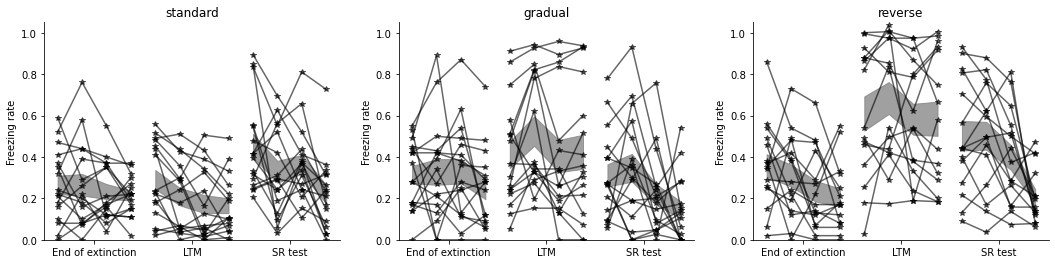

In [37]:
import seaborn as sns
exp = 'sp'
fig, axes = plt.subplots(1,3,figsize=(18,4))
for cond, ax in zip(conds, axes):
    ax.set_title(cond)
    d = pd.read_csv(exp + '_' + cond + '.csv', header=None).values
    tmp = np.concatenate((d[:, trial_index['sp']['last4cue']], d[:, trial_index['sp']['memory']], d[:, trial_index['sp']['test']]), axis=1)
    for i, interval in enumerate([[0,1,2,3],[4,5,6,7],[8,9,10,11]]):
        for i_rat in range(tmp.shape[0]):
            ax.plot(np.arange(4)+i*4, tmp[i_rat,interval], 'k*-', alpha=0.6)
        ax.fill_between(np.arange(4)+i*4, y1=np.mean(tmp[:,interval], axis=0) - sem(tmp[:,interval], axis=0), y2=np.mean(tmp[:,interval], axis=0) + sem(tmp[:,interval], axis=0), color='grey', alpha=0.75)
    sns.despine()
    ax.set(xticks=[1.5,5.5,9.5], xticklabels=['End of extinction', 'LTM', 'SR test'])
    ax.set(ylim=[0,1.05], ylabel='Freezing rate')

#### spontaneous recovery ~ time (standard extinction)

In [11]:
ttest_rel(data['sp', 'standard', 'memory'], data['sp', 'standard', 'last4cue'])

Ttest_relResult(statistic=-1.7971180867180823, pvalue=0.09247625930346487)

In [12]:
ttest_rel(data['sp', 'standard', 'test'], data['sp', 'standard', 'last4cue'])

Ttest_relResult(statistic=3.261114739383725, pvalue=0.005262077099558268)

### compare experiments for last4cue

In [36]:
formula = 'freeze_rate ~ C(exp) * C(cond)'
model = ols(formula, df[df['trial_type']=='last4cue'].groupby(['rat', 'exp', 'cond']).mean().reset_index()).fit()
aov_table = anova_lm(model, typ=1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(exp),1.0,0.060874,0.060874,3.281918,0.074160
C(cond),2.0,0.098110,0.049055,2.644718,0.077825
C(exp):C(cond),2.0,0.018204,0.009102,0.490723,0.614189
Residual,73.0,1.354031,0.018548,NaN,NaN


In [42]:
for cond in conds:
    formula = 'freeze_rate ~ C(exp)'
    model = ols(formula, df[(df['trial_type']=='last4cue') & (df['cond']==cond)].groupby(['rat', 'exp']).mean().reset_index()).fit()
    aov_table = anova_lm(model, typ=1)
    print('\n'+cond)
    print(aov_table)


standard
            df    sum_sq   mean_sq         F   PR(>F)
C(exp)     1.0  0.067106  0.067106  4.377102  0.04818
Residual  22.0  0.337284  0.015331       NaN      NaN

gradual
            df    sum_sq   mean_sq         F    PR(>F)
C(exp)     1.0  0.011827  0.011827  0.469602  0.499235
Residual  26.0  0.654790  0.025184       NaN       NaN

reverse
            df    sum_sq   mean_sq         F    PR(>F)
C(exp)     1.0  0.013526  0.013526  0.934252  0.343019
Residual  25.0  0.361956  0.014478       NaN       NaN


In [45]:
df[df['trial_type']=='last4cue'].groupby(['exp', 'cond']).mean()['freeze_rate']

exp  cond    
re   gradual     0.263487
     reverse     0.232237
     standard    0.131908
sp   gradual     0.305016
     reverse     0.277281
     standard    0.244079
Name: freeze_rate, dtype: float64